## Introduction
-----

In this assignment you will recursively estimate the position of a vehicle along a trajectory using available measurements and a motion model. 

The vehicle is equipped with a very simple type of LIDAR sensor, which returns range and bearing measurements corresponding to individual landmarks in the environment. The global positions of the landmarks are assumed to be known beforehand. We will also assume known data association, that is, which measurment belong to which landmark.

## Motion and Measurement Models
-----

### Motion Model

The vehicle motion model recieves linear and angular velocity odometry readings as inputs, and outputs the state (i.e., the 2D pose) of the vehicle:

\begin{align}
\mathbf{x}_{k} &= \mathbf{x}_{k-1} + T
\begin{bmatrix}
\cos\theta_{k-1} &0 \\
\sin\theta_{k-1} &0 \\
0 &1
\end{bmatrix}
\left(
\begin{bmatrix}
v_k \\
\omega_k
\end{bmatrix}
+ \mathbf{w}_k
\right)
\, , \, \, \, \, \, \mathbf{w}_k = \mathcal{N}\left(\mathbf{0}, \mathbf{Q}\right)
\end{align}

- $\mathbf{x}_k = \left[ x \, y \, \theta \right]^T$ is the current 2D pose of the vehicle
- $v_k$ and $\omega_k$ are the linear and angular velocity odometry readings, which we use as inputs to the model

The process noise $\mathbf{w}_k$ has a (zero mean) normal distribution with a constant covariance $\mathbf{Q}$.

### Measurement Model

The measurement model relates the current pose of the vehicle to the LIDAR range and bearing measurements $\mathbf{y}^l_k = \left[r \, \phi \right]^T$.

\begin{align}
\mathbf{y}^l_k =
\begin{bmatrix}
\sqrt{(x_l - x_k - d\cos\theta_{k})^2 + (y_l - y_k - d\sin\theta_{k})^2} \\
atan2\left(y_l - y_k - d\sin\theta_{k},x_l - x_k - d\cos\theta_{k}\right) - \theta_k
\end{bmatrix}
+
\mathbf{n}^l_k
\, , \, \, \, \, \, \mathbf{n}^l_k = \mathcal{N}\left(\mathbf{0}, \mathbf{R}\right)
\end{align}

- $x_l$ and $y_l$ are the ground truth coordinates of the landmark $l$
- $x_k$ and $y_k$ and $\theta_{k}$ represent the current pose of the vehicle
- $d$ is the known distance between robot center and laser rangefinder (LIDAR)

The landmark measurement noise $\mathbf{n}^l_k$ has a (zero mean) normal distribution with a constant covariance $\mathbf{R}$.

## Getting Started
-----

Since the models above are nonlinear, we recommend using the extended Kalman filter (EKF) as the state estimator.
Specifically, you will need to provide code implementing the following steps:
- the prediction step, which uses odometry measurements and the motion model to produce a state and covariance estimate at a given timestep, and
- the correction step, which uses the range and bearing measurements provided by the LIDAR to correct the pose and pose covariance estimates

### Unpack the Data
First, let's unpack the available data:

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import math

with open('data/data.pickle', 'rb') as f:
    data = pickle.load(f)

t = data['t']  # timestamps [s]
# print(len(t))
x_init  = data['x_init'] # initial x position [m]
y_init  = data['y_init'] # initial y position [m]
th_init = data['th_init'] # initial theta position [rad]

# input signal
v  = data['v']  # translational velocity input [m/s]
om = data['om']  # rotational velocity input [rad/s]

# print(v[2])

# bearing and range measurements, LIDAR constants
b = data['b']  # bearing to each landmarks center in the frame attached to the laser [rad]
r = data['r']  # range measurements [m]
l = data['l']  # x,y positions of landmarks [m]
d = data['d']  # distance between robot center and laser rangefinder [m]
# print(d)
# print(r[0])

Note that distance from the LIDAR frame to the robot center is provided and loaded as an array into the `d` variable.

### Ground Truth
If available, it is useful to plot the ground truth position and orientation before starting the assignment.

<table><tr>
<td> <img src="data/gtruth.png" alt="Ground Truth" width="350"/> </td>
<td> <img src="data/gtruth2.png" alt="Ground Truth" width="350"/> </td>
</tr></table>

Notice that the orientation values are wrapped to the $\left[-\pi,\pi\right]$ range in radians.

### Initializing Parameters

Now that our data is loaded, we can begin getting things set up for our solver. One of the
most important aspects of designing a filter is determining the input and measurement noise covariance matrices, as well as the initial state and covariance values. We set the values here:

In [2]:
v_var = 0.01  # translation velocity variance  


om_var = 0.01 # rotational velocity variance 
r_var = 0.001  # range measurements variance
b_var = 0.001  # bearing measurement variance

Q_km = np.diag([v_var, om_var]) # input noise covariance 
cov_y = np.diag([r_var, b_var])  # measurement noise covariance 
# print(cov_y)

x_est = np.zeros([len(v), 1,3])  # estimated states, x, y, and theta
P_est = np.zeros([len(v), 3, 3])  # state covariance matrices


# F_mat= np.zeros([len(v), 3, 3]) 
# L_mat=np.zeros([len(v), 3, 2]) 

x_est[0] = np.array([x_init, y_init, th_init]) # initial state
# print(x_est[0])
# P_est[0] = np.diag([1, 1, 0.1]) # initial state covariance
P_est[0] = np.diag([1, 0.1, 0.1]) # initial state covariance

**Remember:** that it is neccessary to tune the measurement noise variances `r_var`, `b_var` in order for the filter to perform well!

In order for the orientation estimates to coincide with the bearing measurements, it is also neccessary to wrap all estimated $\theta$ values to the $(-\pi , \pi]$ range.

In [3]:
# Wraps angle to (-pi,pi] range
def wraptopi(x):
    if x > np.pi:
        x = x - (np.floor(x / (2 * np.pi)) + 1) * 2 * np.pi
    elif x < -np.pi:
        x = x + (np.floor(x / (-2 * np.pi)) + 1) * 2 * np.pi
    return x


## Correction Step
-----
First, let's implement the measurement update function, which takes an available landmark measurement $l$ and updates the current state estimate $\mathbf{\check{x}}_k$.
For each landmark measurement received at a given timestep $k$, you should implement the following steps:

- Compute the measurement model Jacobians at $\mathbf{\check{x}}_{k}$
\begin{align}
\mathbf{y}^l_k = &\mathbf{h}(\mathbf{x}_{k}, \mathbf{n}^l_k) \\\\
\mathbf{H}_{k} = \frac{\partial \mathbf{h}}{\partial \mathbf{x}_{k}}\bigg|_{\mathbf{\check{x}}_{k},0}& \, , \, \, \, \,
\mathbf{M}_{k} = \frac{\partial \mathbf{h}}{\partial \mathbf{n}_{k}}\bigg|_{\mathbf{\check{x}}_{k},0} \, .
\end{align}
- Compute the Kalman Gain
\begin{align}
\mathbf{K}_k &= \mathbf{\check{P}}_k \mathbf{H}_k^T \left(\mathbf{H}_k \mathbf{\check{P}}_k \mathbf{H}_k^T + \mathbf{M}_k \mathbf{R}_k \mathbf{M}_k^T \right)^{-1} 
\end{align}
- Correct the predicted state
\begin{align}
\mathbf{\check{y}}^l_k &= \mathbf{h}\left(\mathbf{\check{x}}_k, \mathbf{0}\right) \\
\mathbf{\hat{x}}_k &= \mathbf{\check{x}}_k + \mathbf{K}_k \left(\mathbf{y}^l_k - \mathbf{\check{y}}^l_k\right)
\end{align}
- Correct the covariance
\begin{align}
\mathbf{\hat{P}}_k &= \left(\mathbf{I} - \mathbf{K}_k \mathbf{H}_k \right)\mathbf{\check{P}}_k
\end{align}

In [4]:
def measurement_update(lk, rk, bk, P_check, x_check):
    
    bk=wraptopi(bk)
    x_k=x_check[0][0]
    y_k=x_check[0][1]
    x_check[0][2]=wraptopi(x_check[0][2])
    th_k=x_check[0][2]
    P_k=P_check
    x_l=lk[0]
    y_l=lk[1]
    
    
    dy1_dx=(x_k-x_l)/(np.sqrt((x_k-x_l)**2+(y_k-y_l)**2))
    dy1_dy=(y_k-y_l)/(np.sqrt((x_k-x_l)**2+(y_k-y_l)**2))
    dy1_d_th=0
    
    
    dy2_dx=-(y_k-y_l)/((x_k-x_l)**2+(y_k-y_l)**2)
    dy2_dy=-(-x_k+x_l)/((x_k-x_l)**2+(y_k-y_l)**2)
    dy2_d_th=-1
    
    A=wraptopi(np.arctan2((y_l-y_k),(x_l-x_k))-th_k)
    
    H_k=np.zeros((2,3))
    H_k[0,0]=dy1_dx
    H_k[0,1]=dy1_dy
    H_k[0,2]=dy1_d_th
    H_k[1,0]=dy2_dx
    H_k[1,1]=dy2_dy
    H_k[1,2]=dy2_d_th
    
    M_k=np.array([[1,1],[1,1]])
    R_k=cov_y
    
    first_term= np.dot(np.dot(H_k,P_k),np.transpose(H_k))
    second_term= np.dot(np.dot(M_k,R_k),np.transpose(M_k))
    
    a=first_term+cov_y
    
#     print(P_k)
    
    b=np.linalg.inv(a)
    
    c=np.dot(P_k,np.transpose(H_k))
    K_k=np.dot(c,b)
    
    
    y_k_given=np.array([[rk],[bk]])
    
    
    
    y_k_cap_d=np.sqrt((x_k-x_l)**2+(y_k-y_l)**2)
    y_k_cap_angle=wraptopi(A)
    
    
    
    y_k_cap=np.array([[y_k_cap_d],[y_k_cap_angle]])
    lovesh=np.dot(K_k,(y_k_given-y_k_cap))
    
    
    
    lovesh=np.transpose(lovesh)
    
    
    x_check= x_check+lovesh
    
    x_check[0][2]=wraptopi(x_check[0][2])
    
    
    identity_matrix=np.diag([1,1,1])
#     identity_matrix=np.identity(3)
#     identity
    covariance_gain= identity_matrix-np.dot(K_k,H_k)
    
    
    P_k= np.dot(covariance_gain,P_k)
    
    P_check=P_k
  
    
    return x_check, P_check


## Prediction Step
-----
Now, implement the main filter loop, defining the prediction step of the EKF using the motion model provided:

\begin{align}
\mathbf{\check{x}}_k &= \mathbf{f}\left(\mathbf{\hat{x}}_{k-1}, \mathbf{u}_{k-1}, \mathbf{0} \right) \\
\mathbf{\check{P}}_k &= \mathbf{F}_{k-1}\mathbf{\hat{P}}_{k-1}\mathbf{F}_{k-1}^T + \mathbf{L}_{k-1}\mathbf{Q}_{k-1}\mathbf{L}_{k-1}^T \, .
\end{align}

Where

\begin{align}
\mathbf{F}_{k-1} = \frac{\partial \mathbf{f}}{\partial \mathbf{x}_{k-1}}\bigg|_{\mathbf{\hat{x}}_{k-1},\mathbf{u}_{k},0}  \, , \, \, \, \,
\mathbf{L}_{k-1} = \frac{\partial \mathbf{f}}{\partial \mathbf{w}_{k}}\bigg|_{\mathbf{\hat{x}}_{k-1},\mathbf{u}_{k},0} \, .
\end{align}

In [6]:
#### 5. Main Filter Loop #######################################################################
for k in range(1, len(t)):  # start at 1 because we've set the initial prediciton

    delta_t = t[k] - t[k - 1]  # time step (difference between timestamps)
    T=delta_t

    theta_inst=x_est[k-1][0][2]
    
    
    theta_inst=wraptopi(theta_inst)
    
    arr_1= np.array([[np.cos(theta_inst),0],[np.sin(theta_inst),0],[0,1]])
    
    input_mat=np.array([[v[k]],[om[k]]])
    
    bich_ki_matrix=delta_t*(np.dot(arr_1,input_mat))

    x_est[k]= x_est[k-1] + np.transpose(bich_ki_matrix)

    F_mat= np.array([[1,0,-T*v[k]*np.sin(theta_inst)],[0,1,T*v[k]*np.cos(theta_inst)],[0,0,1]])
    
    L_mat= np.array([[(np.cos(theta_inst)),0],[(np.sin(theta_inst)),0],[0,1]])
    
    L_mat=T*L_mat

    first_term= np.dot(F_mat,np.dot(P_est[k-1],np.transpose(F_mat)))
    
    second_term= np.dot(L_mat,np.dot(Q_km,np.transpose(L_mat)))
    
    
    
    P_est[k]= first_term + second_term
    
    
    
    
    # 1. Update state with odometry readings (remember to wrap the angles to [-pi,pi])
    x_check = np.zeros((1,3))
    
    
    
    x_check[0][2]=  wraptopi(x_est[k][0][2])
    x_check[0][0]=  x_est[k][0][0]
    x_check[0][1]=  x_est[k][0][1]
    

    
    P_check= P_est[k]
    
    # 2. Motion model jacobian with respect to last state
#     F_km = np.zeros([3, 3])

    # 3. Motion model jacobian with respect to noise
#     L_km = np.zeros([3, 2])

    # 4. Propagate uncertainty

    # 5. Update state estimate using available landmark measurements
    for i in range(len(r[k])):

        x_check, P_check = measurement_update(l[i], r[k, i], b[k, i], P_check, x_check)
        

    # Set final state predictions for timestep
    x_est[k, 0,1] = x_check[0][0]
    x_est[k, 0,1] = x_check[0][1]
    x_est[k,0, 2] = x_check[0][2]
    P_est[k, :, :] = P_check

Let's plot the resulting state estimates:

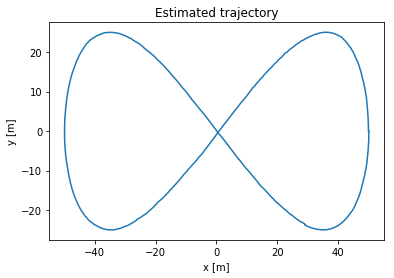

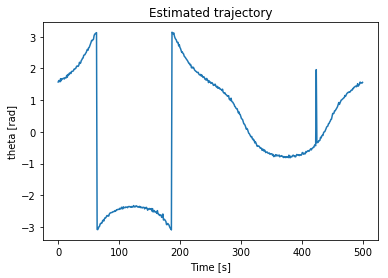

In [7]:
e_fig = plt.figure()
ax = e_fig.add_subplot(111)
ax.plot(x_est[:,0, 0], x_est[:, 0,1])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('Estimated trajectory')
plt.show()

e_fig = plt.figure()
ax = e_fig.add_subplot(111)
ax.plot(t[:], x_est[:,0, 2])
ax.set_xlabel('Time [s]')
ax.set_ylabel('theta [rad]')
ax.set_title('Estimated trajectory')
plt.show()

Are you satisfied wth your results? The resulting trajectory should closely resemble the ground truth, with minor "jumps" in the orientation estimate due to angle wrapping. If this is the case, run the code below to produce your solution file.

In [8]:
with open('submission.pkl', 'wb') as f:
    pickle.dump(x_est, f, pickle.HIGHEST_PROTOCOL)

In [9]:
import sympy as sp
from sympy import *
import math

xl,yl,d,theta,x_k,y_k=symbols('xl yl d theta_k x_k y_k')
sp.init_printing(use_latex=True)
X_K=sp.Matrix([[sqrt((xl-x_k)**2+(yl-y_k)**2)],[atan2((yl-y_k),(xl-x_k))-theta]])
state=sp.Matrix([x_k,y_k,theta])
# sp.Matrix([[atan2((yl-y_k-d*sin(theta)),(xl-x_k-d*cos(theta)))-theta]])
# print(X_K)
X_K.jacobian(state)

⎡           xₖ - xl                         yₖ - yl                ⎤
⎢──────────────────────────────  ──────────────────────────────  0 ⎥
⎢   ___________________________     ___________________________    ⎥
⎢  ╱           2             2     ╱           2             2     ⎥
⎢╲╱  (-xₖ + xl)  + (-yₖ + yl)    ╲╱  (-xₖ + xl)  + (-yₖ + yl)      ⎥
⎢                                                                  ⎥
⎢         -(yₖ - yl)                      -(-xₖ + xl)              ⎥
⎢  ─────────────────────────       ─────────────────────────     -1⎥
⎢            2             2                 2             2       ⎥
⎣  (-xₖ + xl)  + (-yₖ + yl)        (-xₖ + xl)  + (-yₖ + yl)        ⎦

In [10]:
import sympy as sp
from sympy import *
import math

xl,yl,d,theta,x_k,y_k,v_k,w_k,T,a,b=symbols('xl yl d theta_k-1 x_k y_k v_k w_k T a b')
sp.init_printing(use_latex=True)

# X_K=sp.Matrix([[v_k],[w_k]])+sp.Matrix([[a],[b]])
X_K=sp.Matrix([[x_k],[y_k],[theta]])+T*sp.Matrix([[cos(theta),0],[sin(theta),0],[0,1]])@(sp.Matrix([[v_k],[w_k]])+sp.Matrix([[a],[b]]))
state=sp.Matrix([a,b])
# sp.Matrix([[atan2((yl-y_k-d*sin(theta)),(xl-x_k-d*cos(theta)))-theta]])
# X_K
X_K.jacobian(state)

⎡T⋅cos(θₖ₋₁)  0⎤
⎢              ⎥
⎢T⋅sin(θₖ₋₁)  0⎥
⎢              ⎥
⎣     0       T⎦